In [223]:
import matplotlib.pyplot as plt
from typing import List, Tuple
import itertools

In [224]:
Headers = List[str]
MatrixSizes = List[int]
BandWidths = List[List[float]]

In [225]:
def read_data(file_name: str) -> Tuple[Headers, MatrixSizes, BandWidths]:
    headers: Headers = []
    matrix_sizes: MatrixSizes = []
    bandwiths: BandWidths = []

    with open(file_name) as fp:
        headers = [word.strip() for word in fp.readline().strip().split(",")]
        for line in fp:
            matrix_size, *_bandwith = line.strip().split(",")
            matrix_sizes.append(int(matrix_size))
            bandwiths.append([float(x) for x in _bandwith])  # type: ignore
    return headers, matrix_sizes, bandwiths

## Blocking

### Bandwith

In [226]:
headers, matrix_sizes, bandwiths = read_data("transpose_out.csv")

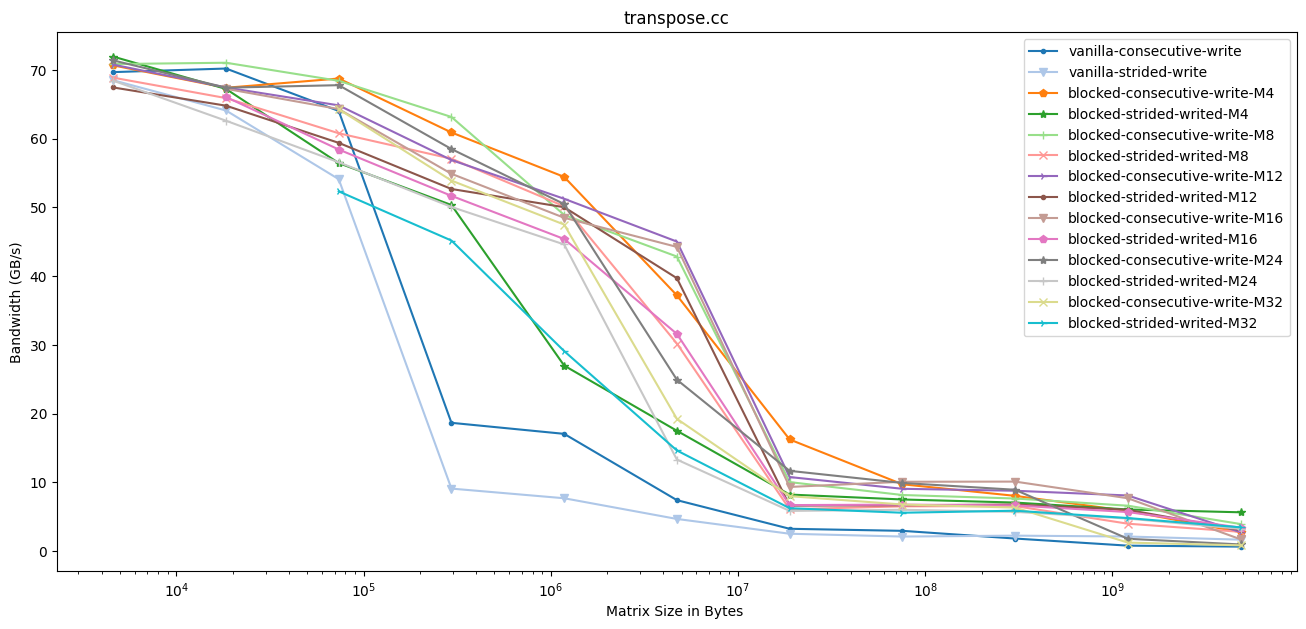

In [227]:
cm = plt.get_cmap("tab20")
num_colors: int = 14
colors = [cm(1.0*i/num_colors) for i in range(num_colors)]
marker = itertools.cycle((".", "v", "p", "*", "+", "x", "4")) 
for i, header in enumerate(headers[1:]):
    plt.plot([n*n*8 for j,n in enumerate(matrix_sizes) if bandwiths[j][i]!=-1.0], [bandwith[i] for bandwith in bandwiths if bandwith[i] != -1.0], label=header, marker=next(marker), color=colors[i])
plt.legend()
plt.xlabel("Matrix Size in Bytes ")
plt.ylabel("Bandwidth (GB/s)")
plt.xscale("log")
plt.title("transpose.cc")
fig = plt.gcf()
fig.set_size_inches(16, 7)

### Runtimes

In [228]:
headers, matrix_sizes, bandwiths = read_data("transpose_runtimes.csv")

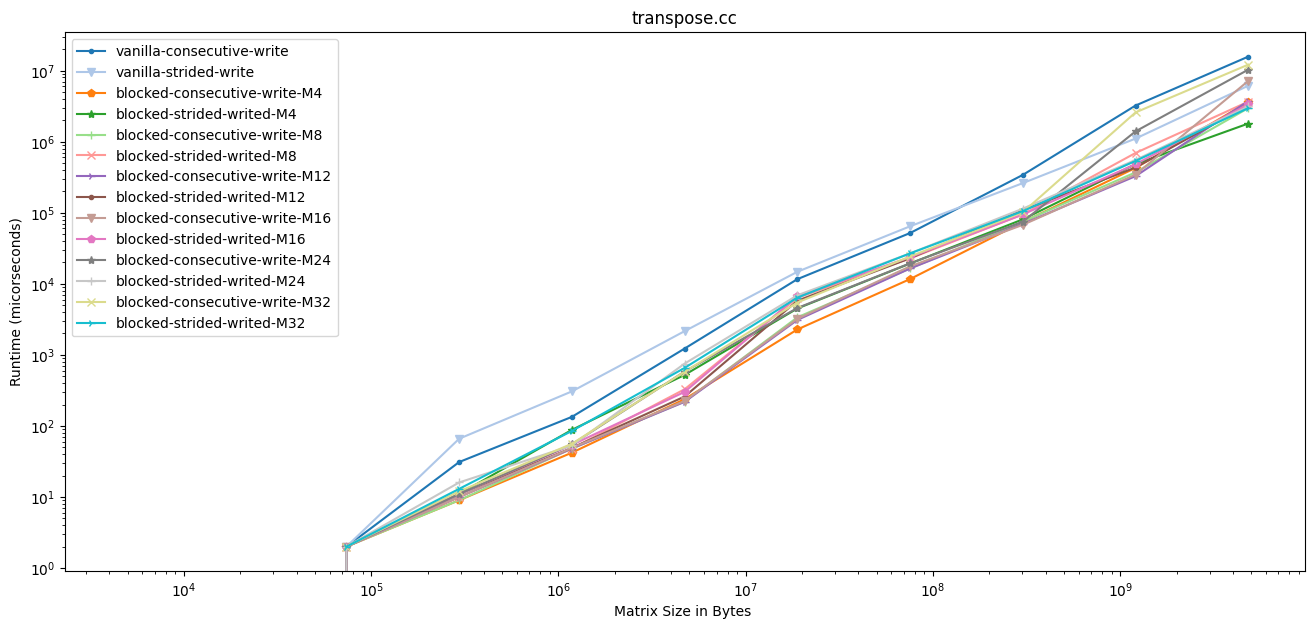

In [229]:
cm = plt.get_cmap("tab20")
num_colors: int = 14
colors = [cm(1.0*i/num_colors) for i in range(num_colors)]
marker = itertools.cycle((".", "v", "p", "*", "+", "x", "4")) 
for i, header in enumerate(headers[1:]):
    plt.plot([n*n*8 for j,n in enumerate(matrix_sizes) if bandwiths[j][i]!=-1.0], [bandwith[i] for bandwith in bandwiths if bandwith[i] != -1.0], label=header, marker=next(marker), color=colors[i])
plt.legend()
plt.xlabel("Matrix Size in Bytes ")
plt.ylabel("Runtime (micorseconds)")
plt.xscale("log")
plt.yscale("log")
plt.title("transpose.cc")
fig = plt.gcf()
fig.set_size_inches(16, 7)

### Interpretation

Strided Write vs Consecutive Write:  
- Generally, consecutive write is faster up to {10^8}bytes ~ 100MB  
- We have double the read bandwidth than write bandwidth, theoretically  
    - Writes are "bottlenecks", so consecutive writes should exploit the cache better  

> Why is strided write better for big sizes?
>> We assume it has to do with TLB misses.
```
64 L1 TLB entries, fully associative
2048 L2 TLB entries, 16-way associative
```	

For this system a block size of 4 seems to be the best choice.
> Why?
>> $4*8B = 32B$ | A cache line reads 64B anyway, so block size of 8 would be better!?


## AVX

### Bandwith

In [230]:
headers, matrix_sizes, bandwiths = read_data("transpose_avx_out.csv")

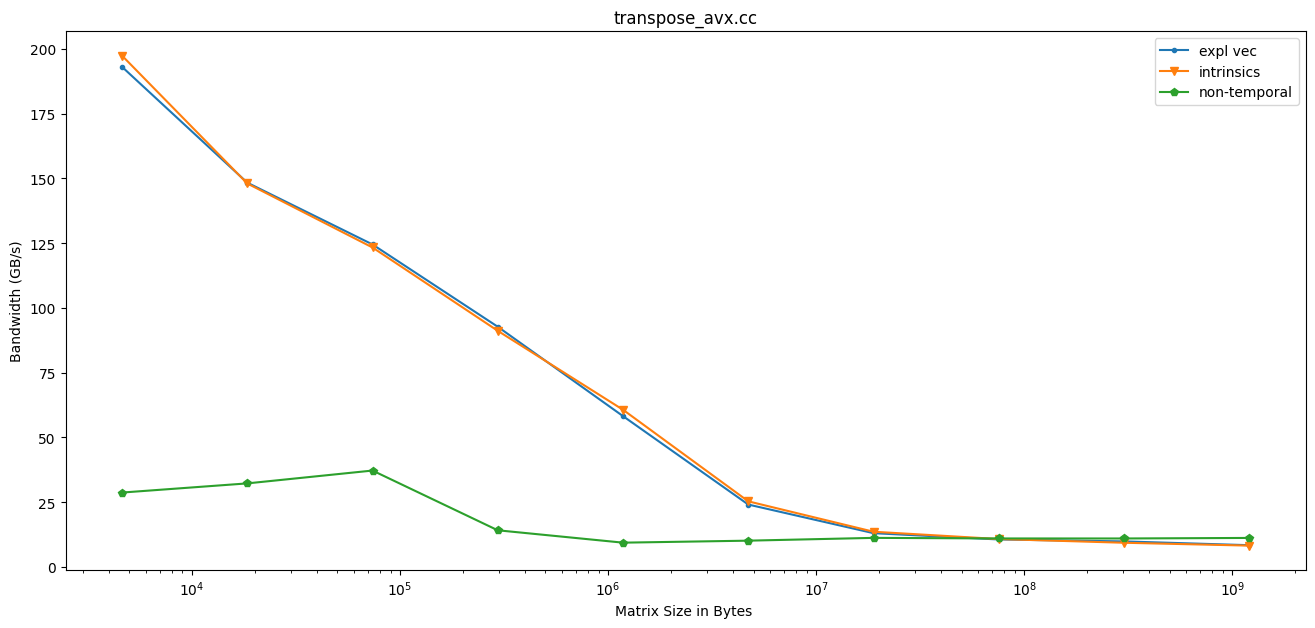

In [231]:
cm = plt.get_cmap("tab20")
num_colors: int = 14
marker = itertools.cycle((".", "v", "p", "*", "+", "x", "4")) 
for i, header in enumerate(headers[1:]):
    plt.plot([n*n*8 for j,n in enumerate(matrix_sizes) if bandwiths[j][i]!=-1.0], [bandwith[i] for bandwith in bandwiths if bandwith[i] != -1.0], label=header, marker=next(marker))
plt.legend()
plt.xlabel("Matrix Size in Bytes ")
plt.ylabel("Bandwidth (GB/s)")
plt.xscale("log")
plt.title("transpose_avx.cc")
fig = plt.gcf()
fig.set_size_inches(16, 7)

### Runtimes

In [232]:
headers, matrix_sizes, bandwiths = read_data("transpose_avx_runtimes.csv")

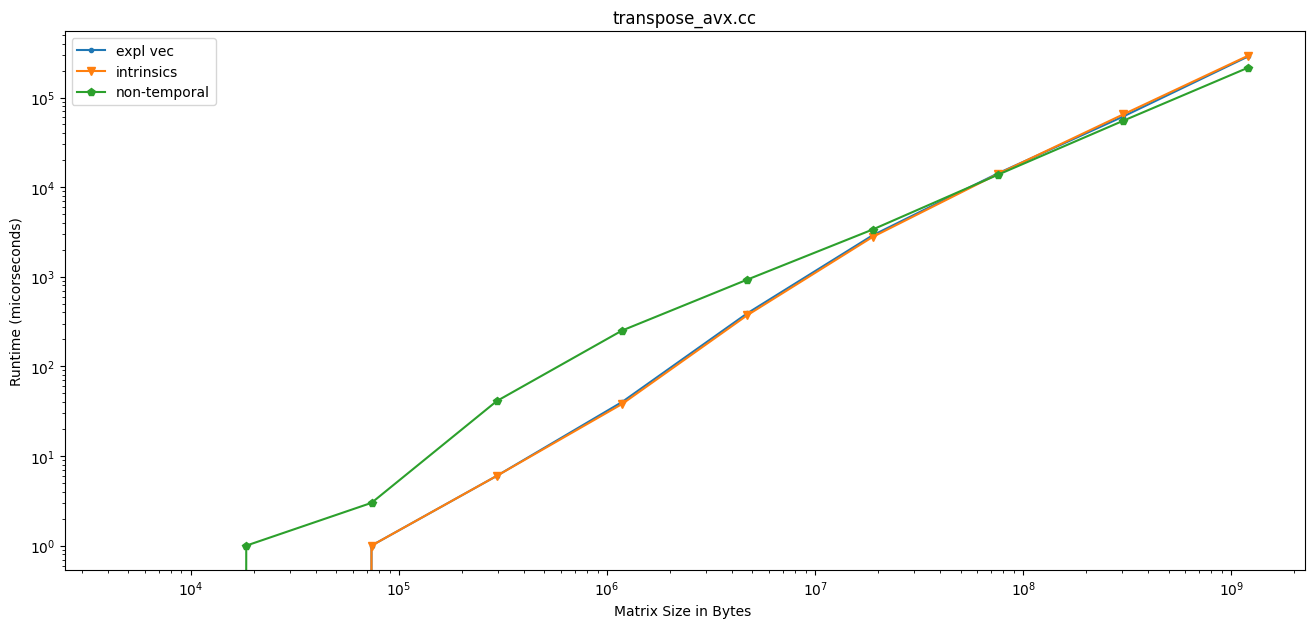

In [234]:
marker = itertools.cycle((".", "v", "p", "*", "+", "x", "4")) 
for i, header in enumerate(headers[1:]):
    plt.plot([n*n*8 for j,n in enumerate(matrix_sizes) if bandwiths[j][i]!=-1.0], [bandwith[i] for bandwith in bandwiths if bandwith[i] != -1.0], label=header, marker=next(marker))
plt.legend()
plt.xlabel("Matrix Size in Bytes ")
plt.ylabel("Runtime (micorseconds)")
plt.xscale("log")
plt.yscale("log")
plt.title("transpose_avx.cc")
fig = plt.gcf()
fig.set_size_inches(16, 7)

### Interpretation
L3 Cache: 32MiB

The results of ``expl vec`` and ``intrinsics`` are almost identical, as internally the ``VCL`` library uses intrinsics for our system. The ``expl vec`` version might generally be a bit slower because of the overhead of the library but the difference is in margin of error.

At a matrix size of $1536 \times 1536$`(18MiB)` almost both matrices fit completely in L1 + L2 + L3 cache, so the `non-temporal` is still slower as it's bottlenecked by the main memory bandwidth.  
Starting at a matrix size of $3072 \times 3072$`(72MiB)` the `non-temporal` version is faster as it doesen't have to cache the written results, which keeps more space for the read operations.


### Memory Alignment
Memory access is aligned if the accessed data is a multiple of the word size. So for modern 64-bit systems, memory access is aligned if the address is a multiple of 8bytes.  
The CPU always reads data in its word size, so misaligned data has to be read in two steps.

In our experiment, if the data is not properly aligned, then we would expect the runtime to be slower roughly by a factor of 2, as we have to access any data in two steps.